In [1]:
import numpy as np
import pandas as pd
from spec_id import Scale_model,Gen_spec,Median_w_Error_cont
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import grizli
from glob import glob
from scipy.interpolate import interp1d
import os
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)
pandas2ri.activate()

### set home for files
hpath = os.environ['HOME'] + '/'

In [2]:
galDB = pd.read_pickle('../data/upd_galDB.pkl')
lzDB = galDB.query('z_grism < 1.16')
mzDB = galDB.query('1.16 < z_grism < 1.3')
hzDB = galDB.query('1.3 < z_grism < 1.45')
uhzDB = galDB.query('1.45 < z_grism')


metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
dust=np.round(np.arange(0.0,1.1,0.1),1)
M,A=np.meshgrid(metal,age)

In [23]:
sp = Gen_spec(galDB.gids[0],galDB.z_grism[0])

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.op

In [4]:
lwa_grid_t = np.load('../data/light_weight_scaling_t.npy')

In [5]:
lwa_grid_t.shape

(31, 56)

In [6]:
lwa_grid = np.load('../data/light_weight_scaling_3.npy')
lwa = lwa_grid[17].T[7]

In [39]:

ultau = np.append(0, np.power(10, np.array(tau)[1:] - 9))

lim = 1
diff = []
percdiff = []
for u in galDB.index:
    chigrid1 = []
    chigrid2 = []
    sp = Gen_spec(galDB.gids[u],galDB.z_grism[u])
    for idt in range(len(tau)-lim):
        lwa1 = lwa_grid_t[idt]
        lwa2 = lwa_grid[17].T[idt]
        chi1 = np.zeros(age.size)
        chi2 = np.zeros(age.size)

        amt1=0
        amt2=0

        for iii in range(age.size):
            if age[iii] > lwa1[-1]:
                amt1 +=1
            if age[iii] > lwa2[-1]:
                amt2 +=1
        for i in range(len(age)):
            wv,fl = np.load(hpath + 'fsps_models_for_fit/fsps_spec/m0.019_a{0}_t{1}_spec.npy'.format(age[i],tau[idt]))
            sp.Sim_spec_mult(wv,fl)
            ifl = interp1d(sp.mwv,sp.fl)(sp.gal_wv)
            ifl /= sp.filt
            ifl *= Scale_model(sp.gal_fl,sp.gal_er,ifl)    
            chi1[i]=sum(((sp.gal_fl - ifl)/sp.gal_er)**2)

            wv,fl = np.load(hpath + 'fsps_models_for_fit/fsps_spec/m0.019_a{0}_dt{1}_spec.npy'.format(age[i],tau[idt]))
            sp.Sim_spec_mult(wv,fl)
            ifl = interp1d(sp.mwv,sp.fl)(sp.gal_wv)
            ifl /= sp.filt
            ifl *= Scale_model(sp.gal_fl,sp.gal_er,ifl)    
            chi2[i]=sum(((sp.gal_fl - ifl)/sp.gal_er)**2)

        dist = interp1d(lwa1,chi1)(age[:-amt1])
        nchi1 = np.append(dist,np.repeat(1E9, amt1))

        dist = interp1d(lwa2,chi2)(age[:-amt2])
        nchi2 = np.append(dist,np.repeat(1E9, amt2))

        chigrid1.append(nchi1)
        chigrid2.append(nchi2)

    p1 = np.exp(-np.array(chigrid1)/2)
    p2 = np.exp(-np.array(chigrid2)/2)

    Pt1 = np.trapz(p1.T, ultau[:-lim], axis=1)
    Pt2 = np.trapz(p2.T, ultau[:-lim], axis=1)

    Pt1 /= np.trapz(Pt1,age)
    Pt2 /= np.trapz(Pt2,age)

    m1,l1,h1 = Median_w_Error_cont(Pt1,age)
    m2,l2,h2 = Median_w_Error_cont(Pt2,age)

    diff.append(m2-m1)

    percdiff.append((m2-m1)/ m2)
#     plt.figure(figsize=[8,8])

#     plt.plot(age,Pt1,'r',label='t')
#     plt.plot(age,Pt2,'b',label='dt')
#     plt.legend()

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.op

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


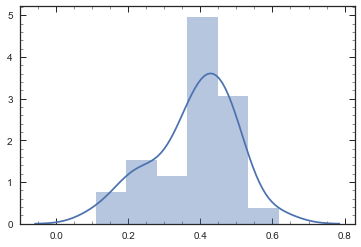

In [35]:
sea.distplot(diff,)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


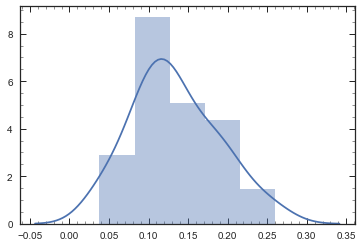

In [40]:
sea.distplot(percdiff)

In [38]:
np.median(percdiff)

0.14035916824196604